# Tanzanian Water Wells
By Jonathan Nunez

# Business Understanding
As a developing country, Tanzania struggles with providing clean water to its population of over 57,000,000. As it is now, there are many water points that have already been built throughout the country, but some need repair while others have failed altogether. The government of Tanzania may not have the necessary resources to be able to effectively and efficiently check and repair all pumps, and wells at the same time. By using a predictive classifier model the Tanzania government hopes to be able to predict which pumps or wells may need repairs to effectively send out technicians to complete said repairs.

By using information about the sort of pump, year of installation, etc. I am to build a prediction classifier to predict the condition of a water well or pump as either 'functional' or 'non-functional'. Through the predictions of the model, the government of Tanzania may be able to effectively and efficiently allocate the necessary resources to locations that are in desperate need of repairs.

# Data Understanding
The data used for this project was gathered from [Taarifa](https://taarifa.org/) and [Tanzanian Ministry of Water](https://www.maji.go.tz/). The information that can be found in this data set ranges from the year the pump, water well, etc. was first constructed, to who funded the construction of that specific water source. This dataset also provides an abundance of categorical data, for example longitude/latitude, type of water, etc. In total this dataset holds information on over 50,000 plus water sources ranging from first constructed in 1966 up to 2010, and even water sources that are yet to be fully constructed. Since I am trying to predict which pumps and wells are in need of repairs to provide clean water to its population, I will be primarily focusing on rows and columns for pumps and water wells that have a civilian population who heavily rely on these pumps and wells for water. 

# Data Preparation

In [1]:
# Importing tools and modules
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Loading data
tww_data = pd.read_csv('data/training_set_values.csv')
tww_labels = pd.read_csv('data/training_set_labels.csv')

Dropping the 'id' column from the labels data frame as this data frame is sorted in the exact same way as the overall data making it easier to combine both data frames. I also drop columns that are unique identifiers, such as longitude and latitude as data like this doesn't really help with the prediction. There are also columns with different titles but have the same information as a different column minimal variation. For example, the 'quantity' and 'quantity_group', both have the exact information on the how much water remains in the specific water source, so I kept the group column and dropped the other.

In [3]:
# Dropping 'id' column
tww_labels = tww_labels.drop(columns='id')

In [4]:
# Combining the lables data set with overall data
tww_data = pd.concat([tww_data, tww_labels], axis=1)

In [5]:
# Keeping columns that are not unique identifiers, other than 'id'
to_keep = ['id', 'amount_tsh', 'population', 'public_meeting', 'construction_year', 'extraction_type_class', 
           'quantity_group', 'source_type', 'source_class', 'waterpoint_type', 'status_group']

tww_df_keep = tww_data[to_keep]

The 'status_group' column has a 'functional needs repair' value, while the pump can still be considered as 'functional' it is in need of repairs so I replaced all 'functional needs repair' with 'non functional'. In doing so the model will only have two possible results 'functional' or 'non functional'. Changing these values will also help slightly balance out the data. As it is currently, the data is heavily weighted towards 'functional' and that can shift results more towards a ‘functional’ result when in fact the pump could be broken.

In [6]:
# Replacing 'functional needs repair' with 'non functional'
tww_df = tww_df_keep.copy()
tww_df['status_group'] = tww_df['status_group'].replace('functional needs repair', 'non functional')

I also drop rows with a value of 0 in the 'construction_year' column of the data set as well as the 'population' column as this tells me that this specific water pump is yet to be fully constructed, and if the population of where the pump is 0 then that also tells me there is no one around to use the pump and wouldn’t be as high as a priority as compared to a pump with a population of 100+. I also drop rows from the data set where the quantity_group value is 'dry' as a depleted water source won’t see its pump get any use.

In [7]:
# Dropping rows with 0 in 'construction_year' and 'population'
tww_df = tww_df[(tww_df['construction_year'] > 0)]
tww_df = tww_df[(tww_df['population'] > 0)]

In [8]:
# Dropping rows where the quantity_group = 'dry'
tww_df = tww_df[~(tww_df['quantity_group'] == 'dry')]

In the 'public_meeting' column, there are quite a few NaN values. In order to keep as much of this data as possible, I filled in NaN values for 'public_meeting' based on the 'waterpoint_type' values, if it is a communal standpipe (singular or multiple) in the 'waterpoint_type' column then NaN was replaced with True, any other values such as 'hand pump' 'cattle trough', etc. were replaced with False.

In [9]:
tww_df.loc[tww_df['waterpoint_type'] == 'communal standpipe', 'public_meeting'] = True
tww_df.loc[tww_df['waterpoint_type'] == 'communal standpipe multiple', 'public_meeting'] = True
tww_df['public_meeting'] = tww_df['public_meeting'].fillna(False)

In [10]:
tww_df.reset_index(drop=True)

,id,amount_tsh,population,public_meeting,construction_year,extraction_type_class,quantity_group,source_type,source_class,waterpoint_type,status_group
0,69572,6000.0,109,True,1999,gravity,enough,spring,groundwater,communal standpipe,functional
1,8776,0.0,280,True,2010,gravity,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,34310,25.0,250,True,2009,gravity,enough,dam,surface,communal standpipe multiple,functional
3,9944,20.0,1,True,2009,submersible,enough,other,unknown,communal standpipe multiple,functional
4,49056,0.0,345,True,2011,submersible,enough,borehole,groundwater,other,functional
...,...,...,...,...,...,...,...,...,...,...,...
34124,44885,0.0,210,True,1967,gravity,enough,river/lake,surface,communal standpipe,non functional
34125,11164,500.0,89,True,2007,submersible,enough,borehole,groundwater,communal standpipe,non functional
34126,60739,10.0,125,True,1999,gravity,enough,spring,groundwater,communal standpipe,functional
34127,27263,4700.0,56,True,1996,gravity,enough,river/lake,surface,communal standpipe,functional


# Modeling

### K-Nearest Neighbors (KNN)
The model used for this project is K-Nearest Neighbors (KNN). I went with this classifier as its non-parametric, meaning it doesn’t make assumptions based on how the data is distributed. KNN can also adapt to new examples or data points. Because data is stored in memory, when there is new data present, it will adjust and incorporate the new information into future predictions.

In [11]:
# Importing tools and modules
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

from imblearn.over_sampling import SMOTE

In [12]:
# Train test splitting data
X = tww_df.drop(['id', 'status_group'], axis=1)
y = tww_df['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Our data is full of categorical values, in order to be able to use this data with a KNN classifier I first turn the categorical data into numerical values. The following functions taken from the Classification Workflow lecture by Flatiron School, will one hot encode categorical data, and return a dataframe with the encoded values. 

In [13]:
# Both encode_and_concat_feature_train, and encode_and_concat_feature taken from Flatiron School lecture
def encode_and_concat_feature_train(X_train, feature_name):
    """
    Helper function for transforming training data. It takes in the full X dataframe and
    feature name, makes a one-hot encoder, and returns the encoder as well as the dataframe
    with that feature transformed into multiple columns of 1s and 0s
    """
    # make a one-hot encoder and fit it to the training data
    ohe = OneHotEncoder(categories="auto", handle_unknown="ignore")
    single_feature_df = X_train[[feature_name]]
    ohe.fit(single_feature_df)
    
    # call helper function that actually encodes the feature and concats it
    X_train = encode_and_concat_feature(X_train, feature_name, ohe)
    
    return ohe, X_train

def encode_and_concat_feature(X, feature_name, ohe):
    """
    Helper function for transforming a feature into multiple columns of 1s and 0s. Used
    in both training and testing steps. It Takes in the full X dataframe, feature name, 
    and encoder, and returns the dataframe with that feature transformed into multiple
    columns of 1s and 0s
    """
    # create new one-hot encoded df based on the feature
    single_feature_df = X[[feature_name]]
    feature_array = ohe.transform(single_feature_df).toarray()
    ohe_df = pd.DataFrame(feature_array, columns=ohe.categories_[0], index=X.index)
    
    # drop the old feature from X and concat the new one-hot encoded df
    X = X.drop(feature_name, axis=1)
    X = pd.concat([X, ohe_df], axis=1)
    
    return X

encoders = {}


In [14]:
# Onehotencoding categorical data
categorical_feature_names = ['public_meeting', 'extraction_type_class', 'quantity_group', 'source_type', 'source_class',
                             'waterpoint_type']

for categorical_feature in categorical_feature_names:
    ohe, X_train = encode_and_concat_feature_train(X_train, categorical_feature)
    encoders[categorical_feature] = ohe

In [15]:
# Function to quickly get classification scores
def model_eval(y_true, pred):
    '''
    A simple function that takes in train or test data, and predicted results variable, 
    and prints out its Precision, Recall, and F1-Score.
    
    Arguments:
    y_true: y_train or y_test data
    pred: data that has gone through the .predict() function
    '''
    print('Precision Score: ', precision_score(y_true, pred, average='macro'))
    print('Recall Score: ', recall_score(y_true, pred, average='macro'))
    print('F1-Score: ', f1_score(y_true, pred, average='macro'))

Since our current data is heavily weighted towards the 'functional' status, this can easily cause biases in the model's prediction result. To help lower the model bias as much as possible I use Synthetic Minority Over-sampling Technique (SMOTE) to generate synthetic data based off of the data already present to make the data as even as possible. Since KNN is a distance-based machine learning algorithm, I scale the data with a Min Max scaler. I went with a min max scaler to ensure all features are taken into consideration equally and lower the potential of a model bias.

In [16]:
# Balancing Train data
smote = SMOTE()
X_train_resamp, y_train_resamp = smote.fit_resample(X_train, y_train)

In [17]:
# Scaling data
mm_scaler = MinMaxScaler()

In [18]:
mm_scaler.fit(X_train_resamp)

MinMaxScaler()

In [19]:
# Turning our scaled data in a dataframe
X_train_mm_scaled = pd.DataFrame(
    mm_scaler.transform(X_train_resamp),
    index=X_train_resamp.index,
    columns=X_train_resamp.columns
)

### KNN Model 1
For our base model a simple KNN model with all default parameters will be a good starting point to see how this classification model deals with our data. Since this data is rather large with over 30k rows I do use the parameter that will essentially give the model more computing power to help speed things up a bit.

In [20]:
knn_1 = KNeighborsClassifier(n_jobs=4)
knn_1.fit(X_train_mm_scaled, y_train_resamp)

KNeighborsClassifier(n_jobs=4)

In [21]:
y_pred_knn_1 = knn_1.predict(X_train_mm_scaled)

In [22]:
# Checking model scores
model_eval(y_train_resamp, y_pred_knn_1)

Precision Score:  0.832863096491719
Recall Score:  0.8318694238882357
F1-Score:  0.8317438531015499


In [23]:
# Cross Validation
print(cross_val_score(knn_1, X_train_mm_scaled, y_train_resamp))

[0.72441217 0.73098202 0.72130014 0.80944147 0.82137299]


#### KNN Model 1 Evaluation
Not a bad start for our base model, it is a little concerning but not entirely bad that the classification scores are all pretty much the exact same. This tells me that our data is pretty even between 'functional' and 'non-functional' meaning very little chance of the model being biased. That being said, due to how even the data is, it is possible that there may not be enough differences between each feature for the model to reach a definitive prediction.

### KNN Model 2
For KNN model 2 I increased the number of points the model should look at before making its prediction, I did this because a lower value could lead the model to be much more sensitive to noise and outliers that could be found in the data. I also ran the model with a different algorithm meant for complex data as well as 'l1' metric.

In [24]:
# KNN model 2
knn_2 = KNeighborsClassifier(n_neighbors=7,  n_jobs=4, algorithm='ball_tree', metric='l1')
knn_2.fit(X_train_mm_scaled, y_train_resamp)

KNeighborsClassifier(algorithm='ball_tree', metric='l1', n_jobs=4,
                     n_neighbors=7)

In [25]:
y_pred_knn_2 = knn_2.predict(X_train_mm_scaled)

In [26]:
# Checking model scores
model_eval(y_train_resamp, y_pred_knn_2)

Precision Score:  0.8190910936636038
Recall Score:  0.8174147589736496
F1-Score:  0.8171746422048325


In [27]:
# Cross Validation
print(cross_val_score(knn_2, X_train_mm_scaled, y_train_resamp))

[0.7276971  0.72856155 0.7275242  0.8030434  0.81704997]


#### KNN Model 2 Evaluation
KNN Model 2, while its classification scores are lower than our base model it is not as big of a difference as it is only a range of 0.01 to 0.02 points. Comparing our scores to our cross-validation scores shows promising results, Overall this models seems to be doing well with unforseen data, but I believe from this model if I continue increasing the k value then the model will easily underfit.

### KNN Model 3
The previous model yielded great results, but with that being said there is still room for improvements considering how the higher the k value the lower our classification score gets. So, in KNN model 3 I reverted the k value back to the default 5 like the base model. Just like the previous model, I kept the same metric and algorithm as these two parameters have been yielding good results.

In [28]:
# KNN model 3
knn_3 = KNeighborsClassifier(n_neighbors=5, n_jobs=4, algorithm='ball_tree', metric='l1')
knn_3.fit(X_train_mm_scaled, y_train_resamp)

KNeighborsClassifier(algorithm='ball_tree', metric='l1', n_jobs=4)

In [29]:
y_pred_knn_3 = knn_3.predict(X_train_mm_scaled)

In [30]:
# Checking model scores
model_eval(y_train_resamp, y_pred_knn_3)

Precision Score:  0.8345430567742262
Recall Score:  0.8332526454111626
F1-Score:  0.8330916942495941


In [31]:
# Cross Validation
print(cross_val_score(knn_3, X_train_mm_scaled, y_train_resamp))

[0.72648686 0.73530429 0.7257953  0.80511845 0.81618537]


#### KNN Model 3 Evaluation
Out of the three displayed models in this notebook, KNN model 3 yielded the highest classification score averaging at an 83 for our classification scores, but overall .002 higher than our base model. Comparing the classification scores with the cross validation score we can see that the scores are close, just slightly off from the highest cross validation score so there may be slight overfitting but I wouldn’t consider it very concerning.

### KNN Final Model

From the 3 KNN models displayed above, although just slightly higher, KNN model 3 yielded the best results so that will be the model I will use with the test data. But before that I first need to prepare the test data by encoding categorical values and scaling it.

In [32]:
# Preparing Test data for model use
for categorical_feature in categorical_feature_names:
    ohe, X_test = encode_and_concat_feature_train(X_test, categorical_feature)
    encoders[categorical_feature] = ohe

In [33]:
# Balancing Test data with SMOTE
X_test_resamp, y_test_resamp = smote.fit_resample(X_test, y_test)

In [34]:
# Fitting resampled data to scaler
mm_scaler.fit(X_test_resamp)

MinMaxScaler()

In [35]:
# Turning scaled data back into dataframe
X_test_mm_scaled = pd.DataFrame(
    mm_scaler.transform(X_test_resamp),
    index=X_test_resamp.index,
   columns=X_test_resamp.columns
)

In [36]:
# KNN Final model
knn_final = KNeighborsClassifier(n_neighbors=5, n_jobs=4, algorithm='ball_tree', metric='l1')
knn_final.fit(X_test_mm_scaled, y_test_resamp)

KNeighborsClassifier(algorithm='ball_tree', metric='l1', n_jobs=4)

In [37]:
y_pred_knn_final = knn_final.predict(X_test_mm_scaled)

In [38]:
# Checking model scores
model_eval(y_test_resamp, y_pred_knn_final)

Precision Score:  0.8308837878022957
Recall Score:  0.8298835705045278
F1-Score:  0.8297549134905973


In [39]:
# Cross Validation
print(cross_val_score(knn_final, X_test_mm_scaled, y_test_resamp))

[0.7061439  0.69846403 0.70129345 0.76991508 0.81560857]


### Confusion Matrix Plots

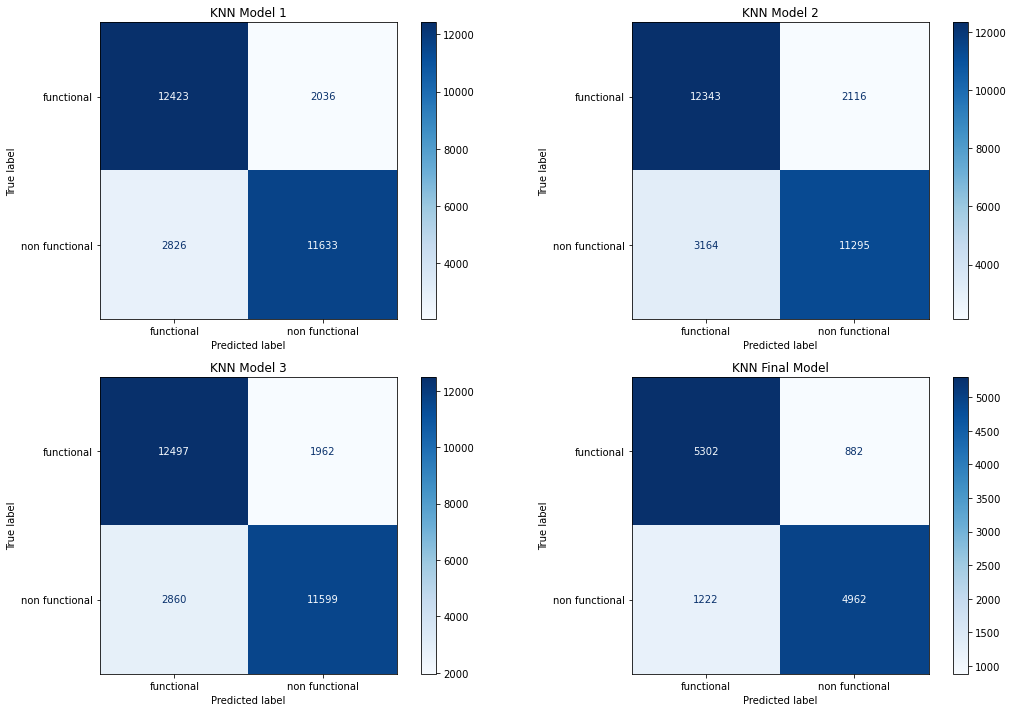

In [40]:
fix, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

ax[0, 0].set_title("KNN Model 1")
ax[0, 1].set_title("KNN Model 2")
ax[1, 0].set_title("KNN Model 3")
ax[1, 1].set_title("KNN Final Model")

plot_confusion_matrix(knn_1, X_train_mm_scaled, y_train_resamp,
                      ax=ax[0, 0], cmap='Blues')
plot_confusion_matrix(knn_2, X_train_mm_scaled, y_train_resamp,
                      ax=ax[0, 1], cmap='Blues')
plot_confusion_matrix(knn_3, X_train_mm_scaled, y_train_resamp,
                      ax=ax[1, 0], cmap='Blues')
plot_confusion_matrix(knn_final, X_test_mm_scaled, y_test_resamp,
                      ax=ax[1, 1], cmap='Blues')
plt.tight_layout();

### Receiver Operating Characteristic Curve Plot

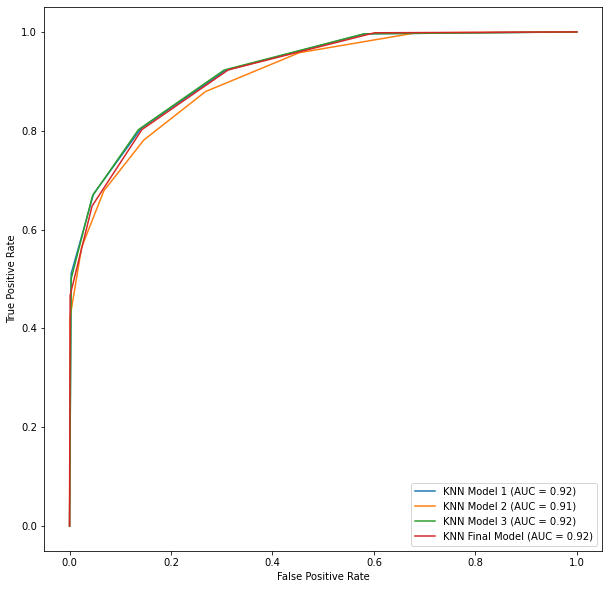

In [41]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_roc_curve(knn_1, X_train_mm_scaled, y_train_resamp, 
               name='KNN Model 1', ax=ax)
plot_roc_curve(knn_2, X_train_mm_scaled, y_train_resamp, 
               name='KNN Model 2', ax=ax)
plot_roc_curve(knn_3, X_train_mm_scaled, y_train_resamp, 
               name='KNN Model 3', ax=ax)
plot_roc_curve(knn_final, X_test_mm_scaled, y_test_resamp, 
               name='KNN Final Model', ax=ax);

# Evaluation
For this project, the **"non functional" category would be seen as the positive outcome, and "functional" as the negative** since we are trying to find which pumps and/or wells are in need of repairs. KNN model 3, which is what the final model is based off, gives the lowest false negatives, and almost gives the lowest false positive. In this case, a lower false negative is beneficial because that means **the model is able to properly categorize between "functional" or "non functional"**. As for the false positives, the final model appears to be putting about 10% as "non functional" but may be actually "functional", considering the overall size of the of the dataset of 50k+ rows, a total of 5k of “non functional” but may possibly actually “functional” is not a bad result.

In terms of performance, the final model got an **average of 83 for its classification scores with the test data**, these results are very similar with those of the training data. With the model’s precision, recall, and f1-scores being almost exact, this tells us the model generalized the data well and is very unlikely to overfit new or unseen data. The final model got an ROC curve score of .92, further solidifying this model’s ability distinguishing between 'functional' and 'non functional' predictions. For cross validation scores, the final model's lowest score showed an **accuracy of 70, while the highest score calculated was an 82** so this model will do fairly well with new data when it is presented.

## Limitations
A limitation this data presents is that it doesn’t necessarily **provide any information on the amount of usage that the individual water sources get on any given day**. We can only really assume that a water source in an area with a population of 100 gets more use than one with a population of 10, but without really knowing usage we **can’t really know if a water source with a population of 10 is actually the one getting much more use than the population of 100**.

The dataset provides location information such as **longitude/latitude, region codes, etc.**, a lot of this information is more of a unique identifier like the 'id' column in the dataset and adds very little benefit to a model’s prediction outcome. Also, **quite a few columns have the same values but titled differently, so in a way its redundant data**. While cleaning these rows out of the dataset wasn’t an issue, it is data that could’ve possibly help with the model predictions if it contained other information.

## Next Steps
As it is now, the final model is not a bad start when it comes to predicting which water pumps are "functional" and "non functional". That being said, **the model could still be fine-tuned or even possibly tweaked further to increase the model’s precision with its predictions**.

If possible, **gathering data on the amount of usage each kind of pump, water well, etc.** gets on any given day can be largely beneficial when predicting which sources are "functional" or "non functional".

This may be more wishful thinking than anything, but if at all possible to **gather location weather information as either mild, moderate, or severe values on either a monthly or yearly span** for the location of the equipment extracting the water can help the model with its prediction, as a **pump or well under constant beating of bad weather is much more susceptible to exterior damage**.